In [32]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math 

# Hello

In [27]:
samples = ["ggHH_SM.root", "TT.root"]# ,"DYJetsToLL_M-50.root","Wjets.root"]
path = "/gpfs/ddn/cms/user/cmsdas/2019/hh_bbtautau/eventTuples_mini/"
sample_name = {"ggHH_SM.root": "Signal", "TT.root" : "TT"}

data = {}
for sample in samples:
    #print(sample)
    file = ROOT.TFile.Open(path+sample)
    tauTau = file.Get("tauTau")
    
    #hist_mass = ROOT.TH2D("hist_mass_"+sample,"2D hist mass", 250, 0, 500, 250, 0, 500);
    
    events = np.zeros((tauTau.GetEntries(), 3))
    n = 0
    for event in tauTau :
        bb_cand = event.jets_p4[0] + event.jets_p4[1]
        events[n, 0] = bb_cand.M()
        events[n, 1] = event.SVfit_p4.M()
        events[n, 2] = event.weight_total
        n += 1
    data[sample] = events

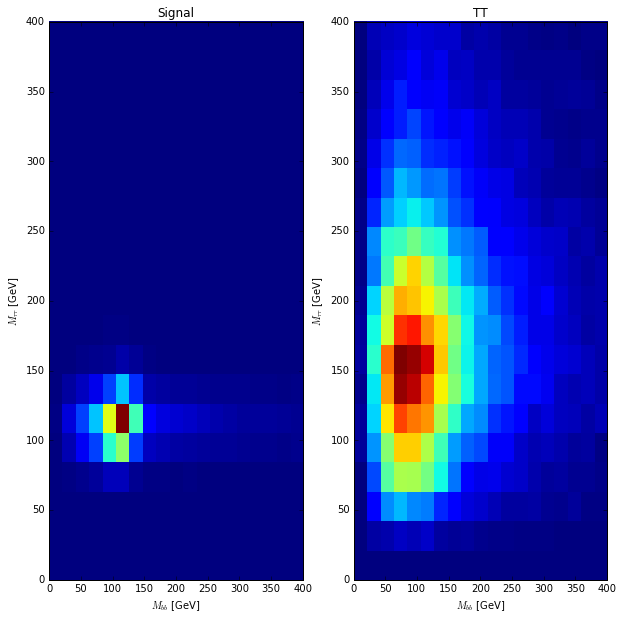

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

n = 0
bins_x = np.linspace(0, 400, 20)
bins_y = np.linspace(0, 400, 20)
for sample, events in data.iteritems():
    ax[n].hist2d(events[:, 0], events[:, 1], weights=events[:, 2], bins=[bins_x, bins_y])
    ax[n].set_xlabel(r'$M_{bb}$ [GeV]')
    ax[n].set_ylabel(r'$M_{\tau\tau}$ [GeV]')
    ax[n].set_title(sample_name[sample])
    
    n += 1
#plt.subplots_adjust(bottom=0.1, right=1.5, top=1.5)
plt.show()

In [81]:
class EllipseMinimization( ROOT.TPyMultiGenFunction ):
    def __init__( self, data, what_to_fit, a, b, x0, y0):
        self.data = data
        self.a = param0
        ROOT.TPyMultiGenFunction.__init__( self, self )

    def NDim(self):
        print 'PYTHON NDim called'
        return 4

    def DoEval(self, args):
        a = args[0]
        b = args[1]
        x0 = args[2]
        y0 = args[3]
        
        n_signal = self.CalcNumEvents('ggHH_SM.root', a, b, x0, y0)
        n_bkg = self.CalcNumEvents('TT.root', a, b, x0, y0)
        
        target = n_signal / math.sqrt(n_bkg) # better formula
        
        return target
    
    def CalcNumEvents(self, sample, a, b, x0, y0):
        events = data[sample]
        x = events[:, 0]
        y = events[:, 1]
        weight = events[:, 2]
        weight_total = np.sum(weight)
        inside_ellipse = (((x-x0)**2) / (a*a) + ((y-y0)**2)/(b*b)) < 1
        n_inside = np.sum(inside_ellipse * weight)
        print("num entries: ", np.count_nonzero(inside_ellipse))
        return n_inside / weight_total
        
    
def FindParams(a, b, x0, y0, data):
    min = ROOT.Math.Factory.CreateMinimizer("GSLMultiMin", "BFGS")
    min.SetMaxFunctionCalls(1000000)
    min.SetMaxIterations(100000)
    min.SetTolerance(0.001)
    min.SetPrintLevel(2)
    ellipse = EllipseMinimization(data)

    step = [1,1,1,1]
    variable = [a,b,x0,y0]

    min.SetFunction(ellipse)

    # Set the free variables to be minimized!
    min.SetVariable(0,"a",variable[0], step[0])
    min.SetVariable(1,"b",variable[1], step[1])
    min.SetVariable(2,"x0",variable[2], step[2])
    min.SetVariable(3,"y0",variable[3], step[3])

    min.Minimize()
    
    a = min.X()[0]
    b = min.X()[1]
    x0 = min.X()[2]
    y0 = min.X()[3]
    
    print("Final", a,b,x0,y0)
    

In [34]:
mean = np.mean(data['ggHH_SM.root'], axis=0)
#print(mean[0])

In [62]:
std = np.std(data['ggHH_SM.root'], axis=0)
std

array([166.63623286,  30.23720964,   0.73054413])

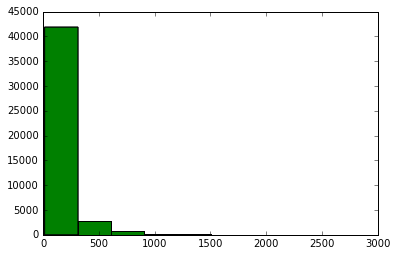

In [64]:
plt.hist(data['ggHH_SM.root'][:, 0])
plt.show()

In [65]:
np.std(data['ggHH_SM.root'][:, 0])

166.636232863567

In [83]:
FindParams(10,10,80,80,data)

PYTHON NDim called
PYTHON NDim called
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 347)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 347)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 347)
('num entries: ', 300)
('num entries: ', 348)
('num entries: ', 299)
('num entries: ', 346)
('num entries: ', 299)
('num entries: ', 348)
('num entries: ', 299)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 300)
('num entries: ', 346)
('num entries: ', 3

In [55]:
ellipse = EllipseMinimization(data)

In [59]:
ellipse.CalcNumEvents('ggHH_SM.root', 10, 10, 151.907, 112.916)

('num entries: ', 650)


0.014418639412300904

In [47]:
ellipse.CalcNumEvents('TT.root', 876426, 148022, 151.907, 112.916)

('num entries: ', 54379)


1.02401163896332e-06

In [50]:
data['ggHH_SM.root'].shape

(45803, 3)